<a href="https://colab.research.google.com/github/chauminhnguyen/optimizer/blob/master/Optimizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Dataset**

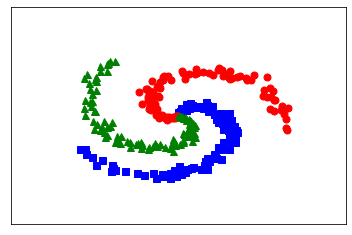

In [ ]:
from __future__ import division, print_function, unicode_literals
import math
import numpy as np
import matplotlib.pyplot as plt

N = 100 # number of points per class
d0 = 2 # dimensionality
C = 3 # number of classes
X = np.zeros((d0, N*C)) # data matrix (each row = single example)
y = np.zeros(N*C, dtype='uint8') # class labels

for j in range(C):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[:,ix] = np.c_[r*np.sin(t), r*np.cos(t)].T
  y[ix] = j
# lets visualize the data:
# plt.scatter(X[:N, 0], X[:N, 1], c=y[:N], s=40, cmap=plt.cm.Spectral)

plt.plot(X[0, :N], X[1, :N], 'bs', markersize = 7);
plt.plot(X[0, N:2*N], X[1, N:2*N], 'ro', markersize = 7);
plt.plot(X[0, 2*N:], X[1, 2*N:], 'g^', markersize = 7);
# plt.axis('off')
plt.xlim([-1.5, 1.5])
plt.ylim([-1.5, 1.5])
cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_ticks([])
cur_axes.axes.get_yaxis().set_ticks([])

plt.savefig('EX.png', bbox_inches='tight', dpi = 600)
plt.show()

#**Loss function**

In [ ]:
def softmax(V):
    e_V = np.exp(V - np.max(V, axis = 0, keepdims = True))
    Z = e_V / e_V.sum(axis = 0)
    return Z

## One-hot coding
from scipy import sparse
def convert_labels(y, C = 3):
    Y = sparse.coo_matrix((np.ones_like(y),
        (y, np.arange(len(y)))), shape = (C, len(y))).toarray()
    return Y

# cost or loss function
def cost(Y, Yhat):
    return -np.sum(Y*np.log(Yhat))/Y.shape[1]

#**Optimizer**

> **SGD**

In [ ]:
def SGD(delta, old, lr):
    new = old - lr * delta
    return new


> **Momemtum**



In [ ]:
def Momentum(delta, old, m, lr, beta1 = 0.9):
    g = delta
    m.append(beta1 * m[-1] + (1 - beta1) * g)
    new = old - lr * m[-1]
    return new

> **Adam**

In [ ]:
def Adam(delta, old, it, lr, s, m, beta1=0.9, beta2=0.999, epsilon=1e-8):
    g = delta
    m.append(beta1 * m[-1] + (1 - beta1) * g)
    s.append(beta2 * s[-1] + (1 - beta2) * np.square(g))
    m_corrected = m[-1] / (1-(beta1**it))
    s_corrected = s[-1] / (1-(beta2**it))
    new = old - lr * (m_corrected) / (np.sqrt(s_corrected) + epsilon)
    return new

#**Main Def**

In [ ]:
def main(opt, max_iter):
    d0 = 2
    d1 = h = 100 # size of hidden layer
    d2 = C = 3
    s_1 = [0]
    m_1 = [0]
    s_2 = [0]
    m_2 = [0]
    s_b1 = [0]
    m_b1 = [0]
    s_b2 = [0]
    m_b2 = [0]
    cost_arr = []

    # initialize parameters randomly
    W1 = 0.01*np.random.randn(d0, d1)
    b1 = np.zeros((d1, 1))
    W2 = 0.01*np.random.randn(d1, d2)
    b2 = np.zeros((d2, 1))

    Y = convert_labels(y, C)
    N = X.shape[1]
    for i in range(1, max_iter):
        ## Feedforward
        Z1 = np.dot(W1.T, X) + b1
        A1 = np.maximum(Z1, 0)
        Z2 = np.dot(W2.T, A1) + b2
        Yhat = softmax(Z2)

        # print loss after each 1000 iterations
        if i %1000 == 0:
            # compute the loss: average cross-entropy loss
            loss = cost(Y, Yhat)
            cost_arr.append(loss)
            print("iter %d, loss: %f" %(i, loss))

        # backpropagation
        
        E2 = (Yhat - Y )/N
        dW2 = np.dot(A1, E2.T)
        db2 = np.sum(E2, axis = 1, keepdims = True)
        if opt == "adam":
            W2 = Adam(dW2, W2, i, 0.5, s_2, m_2)
            b2 = Adam(db2, b2, i, 0.5, s_b2, m_b2)
        elif opt == "momentum":
            W2 = Momentum(dW2, W2, m_2, 0.5)
            b2 = Momentum(db2, b2, m_b2, 0.5)

        E1 = np.dot(W2, E2)
        E1[Z1 <= 0] = 0 # gradient of ReLU
        dW1 = np.dot(X, E1.T)
        db1 = np.sum(E1, axis = 1, keepdims = True)
        if opt == "adam":
            W1 = Adam(dW1, W1, i, 0.5, s_1, m_1)
            b1 = Adam(db1, b1, i, 0.5, s_b1, m_b1)
        
        elif opt == "momentum":
            W1 = Momentum(dW1, W1, m_1, 0.5)
            b1 = Momentum(db1, b1, m_b1, 0.5)
        elif opt == "sgd":
            W2 = SGD(dW2, W2, 0.5)
            b2 = SGD(db2, b2, 0.5)
            W1 = SGD(dW1, W1, 0.5)
            b1 = SGD(db1, b1, 0.5)
    
    return cost_arr

#**Graph**

In [ ]:
import matplotlib.pyplot as plt

def DrawGraph(sgd, momentum, adam, epoch):
    plt.figure(figsize=(10,8))

    plt.plot(epoch, sgd, label="SGD")
    plt.plot(epoch, momentum, label="Momentum")
    plt.plot(epoch, adam, label="Adam")

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


#**Main**

In [ ]:
max_iter = 5000
print("SGD:")
sgd = main('sgd', max_iter)
print("Momentum:")
momentum = main('momentum', max_iter)
print("Adam:")
adam = main('adam', max_iter)

SGD:
iter 1000, loss: 0.210532
iter 2000, loss: 0.084570
iter 3000, loss: 0.055772
iter 4000, loss: 0.044050
Momentum:
iter 1000, loss: 0.244751
iter 2000, loss: 0.113183
iter 3000, loss: 0.068293
iter 4000, loss: 0.050008
Adam:
iter 1000, loss: 0.012954
iter 2000, loss: 0.011434
iter 3000, loss: 0.011530
iter 4000, loss: 0.011661


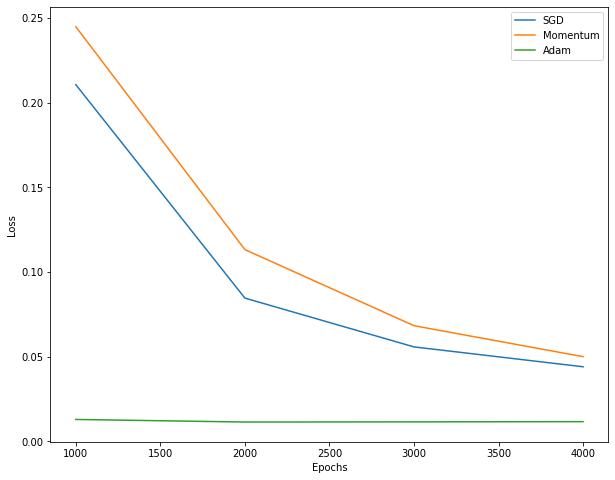

In [ ]:
epoch = [1000, 2000, 3000, 4000]
DrawGraph(sgd, momentum, adam, epoch)